In [2]:
!git clone https://github.com/niazwazir/291ImageDataset.git

Cloning into '291ImageDataset'...
remote: Enumerating objects: 302, done.
remote: Total 302 (delta 0), reused 0 (delta 0), pack-reused 302
Receiving objects: 100% (302/302), 26.62 MiB | 40.33 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [3]:
!ls

291ImageDataset  sample_data


In [6]:
import cv2
import glob
import os
import h5py
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_LR(src,scale):
    LR=[]
    for i in range(len(src)):
        label_=src[i]
        h,w,_=label_.shape
        input_=cv2.resize(label_,(round(w/scale),round(h/scale)),interpolation=cv2.INTER_CUBIC)
        input_=cv2.resize(input_,(w,h),interpolation=cv2.INTER_CUBIC) 
        LR.append(input_)
    return LR

def loadimg(path):
    files = glob.glob(path+"/*")
    src=[] 
    for file in files:
        src.append(cv2.imread(file,1)/255.0)
    return src

def subimg(src,r_field):
    sub_gt=[]
    for i in range(len(src)):
        h,w,_=src[i].shape
        h=h-h%r_field
        w=w-w%r_field
        t=src[i]
        for a in range(0,h,r_field):
            for b in range(0,w,r_field):
                tt=t[a:a+r_field, b:b+r_field]
                if(tt.shape==(r_field,r_field,3)):
                    sub_gt.append(tt.reshape(r_field,r_field,3))
    sub_gtt=np.array(sub_gt) 
    return sub_gtt

def vdsr_model_add(r_field):
    x_in=Input(shape=(r_field,r_field,3),name='input')
    x=Conv2D(64,kernel_size=3,padding='same',activation='relu')(x_in)
    for i in range(19):
        x=Conv2D(64,kernel_size=3,padding='same',activation='relu')(x)
    x_out=Conv2D(3,kernel_size=3,padding='same',name='output')(x)
    add=Add(name='add')([x_in, x_out])
    model=Model(x_in,add)
    return model
  
  
scale=3
r_field=41
src=loadimg("291ImageDataset")
src_LR=create_LR(src,scale)
sub_gt=subimg(src,r_field)
lr=subimg(src_LR,r_field)


model=vdsr_model_add(r_field)
model.summary()
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)
tpu_model.compile(optimizer='adam',  
              loss='mean_squared_error',
              metrics=['mean_squared_error']) 

es = EarlyStopping(monitor='loss', patience=50)
history = tpu_model.fit(lr,sub_gt,epochs=25,batch_size=1024,callbacks=[es])
tpu_model.save_weights("SCALE3VDSR.h5")






__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 41, 41, 3)    0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 41, 41, 64)   1792        input[0][0]                      
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 41, 41, 64)   36928       conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 41, 41, 64)   36928       conv2d_41[0][0]                  
__________________________________________________________________________________________________
conv2d_43 

Using TensorFlow backend.


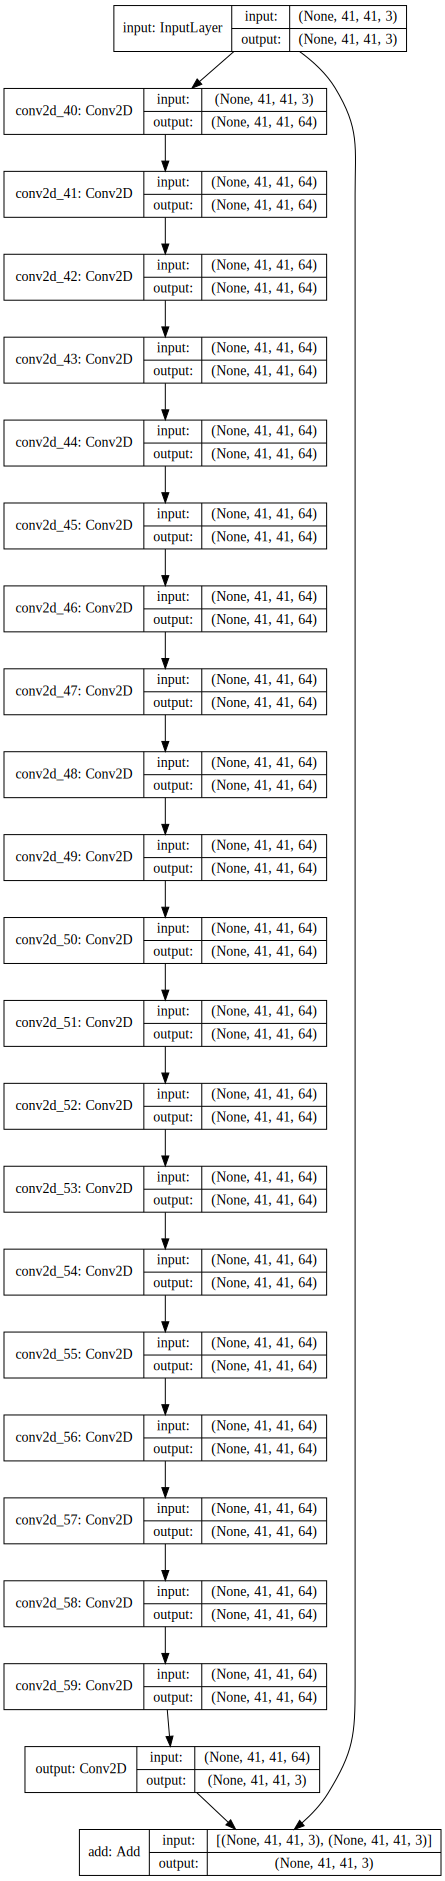

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

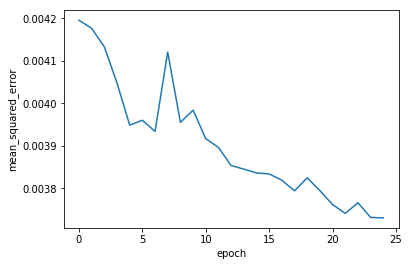

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.show()

In [0]:
from google.colab import files
files.download('SCALE3VDSR.h5')